# ベイズ勉強会 Part 9 非負値行列因子分解

> ベイズ推論による非負値行列因子分解

- toc: true 
- badges: true
- comments: true
- categories: [bayes]
- image: images/mpm.png

ベイズ勉強会資料は『ベイズ推論による機械学習入門』{% fn 1 %}を元に、途中式計算をできるだけ省略せずに行ったものです。

今回は5.2の内容を扱います。

# 非負値行列因子分解とは

非負値行列因子分解(nonnegative matrix factorization, NMF)は、負の値を持たない行列を低次元の行列に分解する技術である。

行列${\bf X} \in \mathbb{R}^{+ D \times N}$を2つの行列${\bf W} \in \mathbb{R}^{+ D \times M}$と${\bf H} \in \mathbb{R}^{+ M \times N}$の積で近似することを目標とする。

このMをD,Nより小さくすることでデータを低次元に落とし込める。

# とりあえず使ってみる

近似推論に入る前にsklearnでとりあえず使ってみる。

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## データのimportと前処理

[Kaggleにあるポケモン(第6世代まで)のデータセット](https://www.kaggle.com/terminus7/pokemon-challenge)を使う。

英語名だとわかりにくいので日本語訳する。 対応表は[ポケモン徹底攻略](https://yakkun.com/swsh/pokemon_en.htm)から拝借した。

日本語訳したものを[gist](https://gist.github.com/Vintea01/9f83dd0b54dd0360067a08fad167fe98)に置いてある。

### 作成過程

In [2]:
#collapse-hide
pokemon = pd.read_csv('data/for0714/pokemon.csv')

# メガシンカは前に、フォルムチェンジは後ろについているので、メガシンカのみ2列目を使う
split = pokemon['Name'].str.split(' ', expand=True)
# 効率的な書き方ではないが行数少ないので素朴に
English = []
for i in range(800):
    if split.iloc[i,0] == 'Mega':
        English.append(split.iloc[i,1])
    else:
        English.append(split.iloc[i,0])
pokemon['English'] = English

# 日本語訳
translate = pd.read_csv('data/for0714/japanese.csv')
pokemon = pd.merge(pokemon, translate, on = 'English', how = 'left')

# 以下特殊事例の処理
# オコリザル
pokemon.loc[62,'Name']='Primeape'
pokemon.loc[62,'Pokedex_No']=57
pokemon.loc[62,'Japanese']='オコリザル'
# バリヤード
pokemon.loc[131,'Pokedex_No']=122
pokemon.loc[131,'Japanese']='バリヤード'
# ホウオウ
pokemon.loc[270,'Pokedex_No']=250
pokemon.loc[270,'Japanese']='ホウオウ'
# ゲンシカイキ
pokemon.loc[422,'Pokedex_No']=382
pokemon.loc[422,'Japanese'] = 'カイオーガ'
pokemon.loc[424,'Pokedex_No']=383
pokemon.loc[424,'Japanese'] = 'グラードン'
# デオキシス
pokemon.loc[429,'Pokedex_No']=386
pokemon.loc[429,'Japanese']='デオキシス'
# マネネ
pokemon.loc[487,'Pokedex_No']=439
pokemon.loc[487,'Japanese']='マネネ'
# ロトム
pokemon.loc[532:537,'Pokedex_No']=479
pokemon.loc[532:537,'Japanese']='ロトム'
# フラベベ
pokemon.loc[737,'Pokedex_No']=669
pokemon.loc[737,'Japanese']='フラベベ'

# 合計種族値の列も作る
pokemon['sum'] = pokemon.iloc[:,4:10].sum(axis=1)

# 出力
# pokemon.drop(['#','English'],axis=1).to_csv('pokemon_data_g6.csv',index=False)

## NMF

In [3]:
pokemon = pd.read_csv('https://gist.githubusercontent.com/Vintea01/'
                      '9f83dd0b54dd0360067a08fad167fe98/raw/'
                      'b7f7f1253515f0151cf5428330fcab0ed26900c8/pokemon_data_g6.csv')

# 種族値だけ取り出す
X = pokemon.iloc[:,3:9]
X

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65
...,...,...,...,...,...,...
795,50,100,150,100,150,50
796,50,160,110,160,110,110
797,80,110,60,150,130,70
798,80,160,60,170,130,80


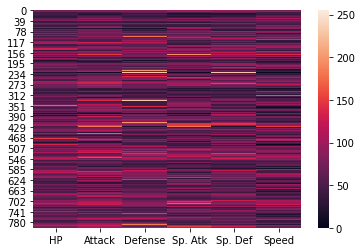

In [4]:
vmin = 0
vmax = np.max(np.max(X))

sns.heatmap(X, vmin=vmin, vmax=vmax)

In [5]:
from sklearn.decomposition import NMF
def fitNMF(X,M):
    model = NMF(n_components=M, init='random', random_state=0)
    W = model.fit_transform(X)
    H = model.components_
    return (W,H)

# M=1でNMF
WH1 = fitNMF(X,1)

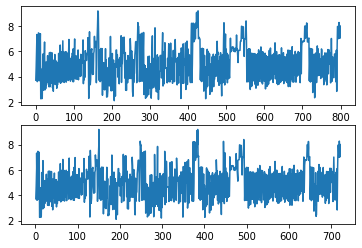

In [6]:
fig, axes = plt.subplots(2,1, figsize=(6, 4))
# データセットでの通し番号を横軸にしてプロット
axes[0].plot(range(800),WH1[0])
# 図鑑番号を横軸にしてプロット
axes[1].plot(pokemon['Pokedex_No'],WH1[0])
# 各世代の最初と終盤(御三家や600族、伝説がいるあたり)で高くなっているのがわかる

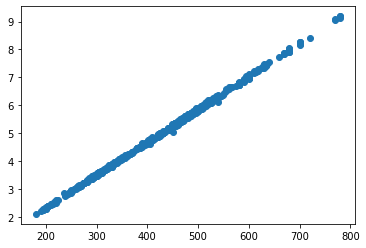

In [7]:
# 特徴量1つなので、合計種族値にほぼ比例する
plt.scatter(pokemon.iloc[:,3:9].sum(axis=1),WH1[0])

In [8]:
pokemon['W1_1'] = WH1[0]
pokemon.loc[np.argsort(- WH1[0], axis=0).flatten()[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1
426,Mega Rayquaza,Dragon,Flying,105,180,100,180,100,115,3,True,384.0,レックウザ,780,9.190523
163,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True,150.0,ミュウツー,780,9.183720
164,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,150.0,ミュウツー,780,9.131998
424,Primal Groudon,Ground,Fire,100,180,160,150,90,90,3,True,383.0,グラードン,770,9.101220
422,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,382.0,カイオーガ,770,9.054753
552,Arceus,Normal,NaN,120,120,120,120,120,120,4,True,493.0,アルセウス,720,8.395973
796,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True,719.0,ディアンシー,700,8.271474
268,Mega Tyranitar,Rock,Dark,100,164,150,95,120,71,2,False,248.0,バンギラス,700,8.264288
494,Mega Garchomp,Dragon,Ground,108,170,115,120,95,92,4,False,445.0,ガブリアス,700,8.251565
711,Kyurem Black Kyurem,Dragon,Ice,125,170,100,120,90,95,5,True,646.0,キュレム,700,8.235804


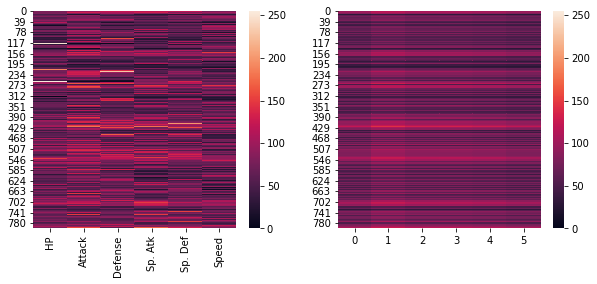

In [9]:
# ヒートマップで確認
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(X, ax=axes[0],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(WH1[0],WH1[1]), ax=axes[1], vmin=vmin, vmax=vmax)

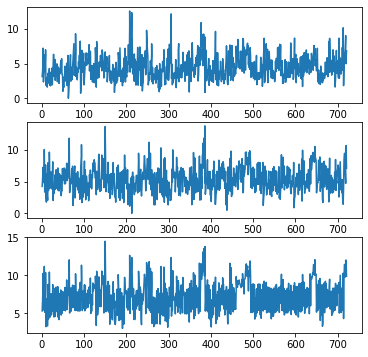

In [10]:
# M=2
WH2 = fitNMF(X,2)
pokemon['W2_1'] = WH2[0][:,0]
pokemon['W2_2'] = WH2[0][:,1]
pokemon['W2_norm'] = np.sqrt(WH2[0][:,0]**2 + WH2[0][:,1]**2) # 原点からの距離
fig, axes = plt.subplots(3,1, figsize=(6, 6))
axes[0].plot(pokemon['Pokedex_No'],WH2[0][:,0])
axes[1].plot(pokemon['Pokedex_No'],WH2[0][:,1])
axes[2].plot(pokemon['Pokedex_No'],pokemon['W2_norm'])

In [11]:
# W2_1の1位はメガハガネール
pokemon.loc[np.argsort(- WH2[0][:,0])[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm
224,Mega Steelix,Steel,Ground,75,125,230,55,95,30,2,False,208.0,ハガネール,610,7.225815,12.535737,1.146028,12.588014
230,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,213.0,ツボツボ,505,5.902231,12.287335,0.000000,12.287335
333,Mega Aggron,Steel,NaN,70,140,230,60,80,50,3,False,306.0,ボスゴドラ,630,7.466571,12.123370,2.097726,12.303518
414,Regirock,Rock,NaN,80,100,200,50,100,50,3,True,377.0,レジロック,580,6.821588,10.871929,2.141495,11.080832
223,Steelix,Steel,Ground,75,85,200,55,65,30,2,False,208.0,ハガネール,510,6.011615,10.270946,1.127756,10.332675
789,Avalugg,Ice,NaN,95,117,184,44,46,28,6,False,713.0,クレベース,514,6.079816,10.130094,1.423286,10.229592
268,Mega Tyranitar,Rock,Dark,100,164,150,95,120,71,2,False,248.0,バンギラス,700,8.264288,9.764774,6.341790,11.643415
456,Bastiodon,Rock,Steel,60,52,168,47,138,30,4,False,411.0,トリデプス,495,5.794392,9.612498,1.403691,9.714446
332,Aggron,Steel,Rock,70,110,180,60,60,50,3,False,306.0,ボスゴドラ,530,6.259436,9.378120,2.622592,9.737922
87,Mega Slowbro,Water,Psychic,95,75,180,130,80,30,1,False,80.0,ヤドラン,590,6.931809,9.280694,4.119200,10.153772


In [12]:
# W2_2の1位はデオキシスアタックフォルム
pokemon.loc[np.argsort(- WH2[0][:,1])[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm
429,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,3,True,386.0,デオキシス,600,7.095015,0.873603,13.707578,13.735388
164,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,150.0,ミュウツー,780,9.131998,4.763079,13.639539,14.447281
428,Deoxys Normal Forme,Psychic,NaN,50,150,50,150,50,150,3,True,386.0,デオキシス,600,7.055994,2.332636,12.022200,12.246407
426,Mega Rayquaza,Dragon,Flying,105,180,100,180,100,115,3,True,384.0,レックウザ,780,9.190523,6.506072,11.842140,13.511671
71,Mega Alakazam,Psychic,NaN,55,50,65,175,95,150,1,False,65.0,フーディン,590,6.825161,2.093347,11.809038,11.993143
163,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True,150.0,ミュウツー,780,9.183720,6.631446,11.690525,13.440403
275,Mega Sceptile,Grass,Dragon,70,110,75,145,85,145,3,False,254.0,ジュカイン,630,7.350223,3.657922,11.172649,11.756211
422,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,382.0,カイオーガ,770,9.054753,6.967974,11.053159,13.066177
162,Mewtwo,Psychic,NaN,106,110,90,154,90,130,1,True,150.0,ミュウツー,680,7.925100,4.905745,10.987712,12.033127
102,Mega Gengar,Ghost,Poison,60,65,80,170,95,130,1,False,94.0,ゲンガー,600,6.972694,3.288247,10.798862,11.288400


上は防御系、下は攻撃系が考慮されていることがわかる。

In [13]:
# 原点からの距離上位10
pokemon.loc[np.argsort(- np.sqrt(WH2[0][:,0]**2 + WH2[0][:,1]**2))[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm
164,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,150.0,ミュウツー,780,9.131998,4.763079,13.639539,14.447281
429,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,3,True,386.0,デオキシス,600,7.095015,0.873603,13.707578,13.735388
426,Mega Rayquaza,Dragon,Flying,105,180,100,180,100,115,3,True,384.0,レックウザ,780,9.190523,6.506072,11.842140,13.511671
163,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True,150.0,ミュウツー,780,9.183720,6.631446,11.690525,13.440403
422,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,382.0,カイオーガ,770,9.054753,6.967974,11.053159,13.066177
424,Primal Groudon,Ground,Fire,100,180,160,150,90,90,3,True,383.0,グラードン,770,9.101220,9.231575,8.658577,12.656735
224,Mega Steelix,Steel,Ground,75,125,230,55,95,30,2,False,208.0,ハガネール,610,7.225815,12.535737,1.146028,12.588014
333,Mega Aggron,Steel,NaN,70,140,230,60,80,50,3,False,306.0,ボスゴドラ,630,7.466571,12.123370,2.097726,12.303518
230,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,213.0,ツボツボ,505,5.902231,12.287335,0.000000,12.287335
428,Deoxys Normal Forme,Psychic,NaN,50,150,50,150,50,150,3,True,386.0,デオキシス,600,7.055994,2.332636,12.022200,12.246407


In [14]:
# つよいポケモン よわいポケモン
# そんなの ひとの かって
# ほんとうに つよい トレーナーなら
# すきなポケモンで かてるように がんばるべき
pokemon.loc[np.argsort(np.sqrt(WH2[0][:,0]**2 + WH2[0][:,1]**2))[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm
206,Sunkern,Grass,NaN,30,30,30,30,30,30,2,False,191.0,ヒマナッツ,180,2.098993,1.820817,2.336336,2.962067
322,Azurill,Normal,Fairy,50,20,40,20,40,20,3,False,298.0,ルリリ,190,2.197064,2.684537,1.588656,3.119385
446,Kricketot,Bug,NaN,37,25,41,25,41,25,4,False,401.0,コロボーシ,194,2.255420,2.554232,1.852783,3.155457
13,Caterpie,Bug,NaN,45,30,35,20,20,45,1,False,10.0,キャタピー,195,2.251764,1.882247,2.584857,3.197552
288,Wurmple,Bug,NaN,45,45,35,20,30,20,3,False,265.0,ケムッソ,195,2.287508,2.627424,1.838265,3.206645
732,Scatterbug,Bug,NaN,38,35,40,27,25,35,6,False,664.0,コフキムシ,200,2.330235,2.248794,2.343573,3.247985
16,Weedle,Bug,Poison,40,35,30,20,20,50,1,False,13.0,ビードル,195,2.256075,1.626743,2.874969,3.303293
17,Kakuna,Bug,Poison,45,25,50,25,25,35,1,False,14.0,コクーン,205,2.373660,2.594490,2.053072,3.308547
139,Magikarp,Water,NaN,20,10,55,15,20,80,1,False,129.0,コイキング,200,2.278770,1.620688,2.929584,3.347999
14,Metapod,Bug,NaN,50,20,55,25,25,30,1,False,11.0,トランセル,205,2.369350,2.849993,1.762960,3.351192


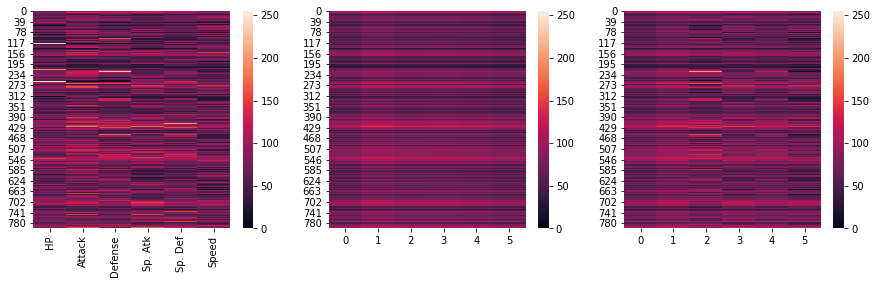

In [15]:
# ヒートマップで確認
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.heatmap(X, ax=axes[0],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(WH1[0],WH1[1]), ax=axes[1],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(WH2[0],WH2[1]), ax=axes[2],vmin=vmin,vmax=vmax)

レコメンドシステム用の関数も書いてみる。

In [16]:
# ポケモン同士の距離を計算
def calc_distance(data, pokemonA, pokemonB):
    A = np.array(data.loc[pokemonA, ['W2_1','W2_2']]).flatten()
    B = np.array(data.loc[pokemonB, ['W2_1','W2_2']]).flatten()
    return np.linalg.norm(A-B)

# 距離が近い上位n種を推薦
def recommendation(data, base_pokemon, n):
    distances = np.array([calc_distance(data,base_pokemon, p) for p in range(800)])
    index = np.argsort(distances)[:n+1]
    return data.loc[index]

In [17]:
# フシギダネに近いポケモン
recommendation(pokemon,0,10)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,1.0,フシギダネ,318,3.716074,3.135670,4.232867,5.267788
649,Karrablast,Bug,NaN,50,75,45,40,45,60,5,False,588.0,カブルモ,315,3.691476,3.044893,4.282051,5.254268
88,Magnemite,Electric,Steel,25,35,70,95,55,45,1,False,81.0,コイル,325,3.806365,3.151154,4.402553,5.414078
506,Finneon,Water,NaN,49,49,56,49,61,66,4,False,456.0,ケイコウオ,330,3.834908,3.203241,4.404721,5.446312
554,Snivy,Grass,NaN,45,45,55,45,55,63,5,False,495.0,ツタージャ,308,3.578294,3.031654,4.062975,5.069388
643,Vanillite,Ice,NaN,36,50,50,65,60,44,5,False,582.0,バニプッチ,305,3.573072,3.016945,4.067858,5.064526
352,Numel,Fire,Ground,60,60,40,65,45,35,3,False,322.0,ドンメル,305,3.575319,2.928664,4.169154,5.094989
674,Cubchoo,Ice,NaN,55,70,40,60,40,40,5,False,613.0,クマシュン,305,3.585578,2.896788,4.225505,5.123111
144,Eevee,Normal,NaN,55,55,50,45,65,55,1,False,133.0,イーブイ,325,3.785743,3.376700,4.111940,5.320729
159,Dratini,Dragon,NaN,41,64,45,50,50,50,1,False,147.0,ミニリュウ,300,3.519529,2.936017,4.046238,4.999223


種族値しか考慮されていないのでレコメンドシステムとしては使い物にならないが

# ベイズ推論で解く

散々遊んだのでNMFのベイズ推論による解法の1例を見てみる。ポケモンの種族値は全て自然数なので、ポアソン分布を使うことができる。

## モデル定義

### 目標

行列${\bf X} \in \mathbb{N}^{D \times N}$を2つの行列${\bf W} \in \mathbb{R}^{+ D \times M}$と${\bf H} \in \mathbb{R}^{+ M \times N}$の積に近似する。

$${\bf X} \approx {\bf W H}$$

> Notes: ここでの$\mathbb{N}$は0を含んだ非負の整数である。

### 登場する変数

- 元の行列: ${\bf X} \in \mathbb{N}^{D \times N}$
- 分解先の行列: ${\bf W} \in \mathbb{R}^{+ D \times M}$,${\bf H} \in \mathbb{R}^{+ M \times N}$
- 潜在変数: ${\bf S} \in \mathbb{N}^{D \times M \times N}$

ここで、${\bf X}$を成分で見たとき

$$
\begin{eqnarray}
    X_{d,n} &=& \Sigma_{m=1}^M S_{d,m,n} \\
    &\approx& \Sigma_{m=1}^M W_{d,m} H_{m,n}
\end{eqnarray}
$$

となるような潜在変数${\bf S} \in \mathbb{N}^{D \times M \times N}$をおいた。このような中間変数を導入することで効率的な近似アルゴリズムを導出できることが知られている。

### それぞれの確率分布

#### ${\bf S}$の分布

潜在変数${\bf S}$は${\bf W},{\bf H}$の成分の積をパラメータに持つポアソン分布に従って発生するとする。

$$
\begin{eqnarray}
    p({\bf S}|{\bf W},{\bf H}) &=& \Pi_{d=1}^D \Pi_{m=1}^M \Pi_{n=1}^N p(S_{d,m,n}|W_{d,m},H_{m,n}) \\
    &=& \Pi_{d=1}^D \Pi_{m=1}^M \Pi_{n=1}^N \mathrm{Poi}(S_{d,m,n}|W_{d,m} H_{m,n})
\end{eqnarray}
$$

#### ${\bf X}$の分布

${\bf X}$を${\bf S}$に条件づけられたデルタ分布に従うとする。

$$
\begin{eqnarray}
    p({\bf X}|{\bf S}) &=& \Pi_{d=1}^D \Pi_{n=1}^N p(X_{d,n}|S_{d,:,n}) \\
    &=& \Pi_{d=1}^D \Pi_{n=1}^N \mathrm{Del}(X_{d,n}|\Sigma_{m=1}^M S_{d,m,n})
\end{eqnarray}
$$

デルタ分布は次のような離散値に対する確率分布である。

$$
\mathrm{Del}(x|z) = \begin{cases}
    1　\mathrm{if}　x=z \\
    0　\mathrm{otherwise}
  \end{cases}
$$

$\Sigma_{m=1}^M S_{d,m,n}$を$X_{d,n}$にそのまま写す確率分布である。

#### ${\bf W},{\bf H}$の分布

各成分がポアソン分布の共役事前分布であるガンマ分布に独立に従うとする。

$$
\begin{eqnarray}
    p({\bf W}) &=& \Pi_{d=1}^D \Pi_{m=1}^M p(W_{d,m}) \\
    &=& \Pi_{d=1}^D \Pi_{m=1}^M \mathrm{Gam}(W_{d,m}|a_W,b_W)
\end{eqnarray}
$$

$$
\begin{eqnarray}
    p({\bf H}) &=& \Pi_{m=1}^M \Pi_{n=1}^N p(H_{m,n}) \\
    &=& \Pi_{m=1}^M \Pi_{n=1}^N \mathrm{Gam}(H_{m,n}|a_H,b_H)
\end{eqnarray}
$$

$a_W,b_W,a_H,b_H$は正の実数であり、ガンマ分布のハイパーパラメータである。

### 同時分布

確率変数の関係をまとめるとNMFに用いるモデルは次のようになる。

$$
p({\bf X},{\bf S},{\bf W},{\bf H}) = p({\bf X}|{\bf S})p({\bf S}|{\bf W},{\bf H})p({\bf W})p({\bf H})
$$

これをDAGで表すと次のようになる。

![](dags/dag5_2.svg)

## 変分推論

### 平均場近似と変分推論の公式

$$
p({\bf S},{\bf W},{\bf H}|{\bf X}) \approx q({\bf S})q({\bf W})q({\bf H})
$$

と仮定して近似事後分布を求める。

> Important: 事後分布に対する近似公式 $$\begin{eqnarray} \ln q(z_i) &=& \langle \ln p(z_1,\dots,z_M|\mathcal{D}) \rangle_{q({\bf Z}_{\verb|\| i} ) }+const. \\ &=& \langle \ln p(\mathcal{D},z_1,\dots,z_M) \rangle_{q({\bf Z}_{\verb|\| i} ) } + const. \end{eqnarray}$$

近似公式を用いて更新式を書く。

$$
\begin{eqnarray}
    \ln q({\bf W}) &=& \langle \ln p({\bf S}|{\bf W},{\bf H}) \rangle_{q({\bf S})q({\bf H})} + \ln p({\bf W}) + const. \\
    &=& \Sigma_{d=1}^D \Sigma_{m=1}^M \{ \Sigma_{n=1}^N \langle \ln p(S_{d,m,n}|W_{d,m},H_{m,n}) \rangle_{q({\bf S})q({\bf H})} + \ln p(W_{d,m}) \} + const. \\
    \ln q({\bf H}) &=& \langle \ln p({\bf S}|{\bf W},{\bf H}) \rangle_{q({\bf S})q({\bf W})} + \ln p({\bf H}) + const. \\
    &=& \Sigma_{m=1}^M \Sigma_{n=1}^N \{ \Sigma_{d=1}^D \langle \ln p(S_{d,m,n}|W_{d,m},H_{m,n}) \rangle_{q({\bf S})q({\bf W})} + \ln p(H_{m,n}) \} + const. \\
    \ln q({\bf S}) &=& \ln p({\bf X}|{\bf S}) + \langle \ln p({\bf S}|{\bf W},{\bf H}) \rangle_{q({\bf W})q({\bf H})} + const. \\
    &=& \Sigma_{d=1}^D \Sigma_{n=1}^N \{ \ln p(X_{d,n}|\Sigma_{m=1}^M S_{d,m,n}) \Sigma_{m=1}^M \langle \ln p(S_{d,m,n}|W_{d,m},H_{m,n}) \rangle_{q({\bf W})q({\bf H})} \} + const.
\end{eqnarray}
$$

### ${\bf W}$の近似事後分布

$\ln q({\bf W})$は$D \times M$個の分布の対数の和で表されているので、$q({\bf W})$は$D \times M$個の独立な分布の積であり、要素$W_{d,m}$に関する近似分布を求めれば導出として十分である。$W_{d,m}$に無関係な項は無視して期待値の部分を計算すると、

$$
\begin{eqnarray}
    \langle \ln p({\bf S}|{\bf W},{\bf H}) \rangle_{q({\bf S})q({\bf H})} &=& \langle \ln \mathrm{Poi} (S_{d,m,n}|W_{d,m} H_{m,n}) \rangle_{q({\bf S})q({\bf H})} \\
    &=& \langle S_{d,m,n} \ln W_{d,m} H_{m,n} - \ln S_{d,m,n} ! - W_{d,m} H_{m,n} \rangle_{q({\bf S})q({\bf H})} \\
    &=& \langle S_{d,m,n} \rangle \ln W_{d,m} - \langle H_{m,n} \rangle W_{d,m} + const.
\end{eqnarray}
$$

また、ガンマ事前分布$p(W_{d,m})$の対数をとると

$$
\ln p(W_{d,m}|a_W,b_W) = (a_W - 1) \ln W_{d,m} - b_W W_{d,m} + const.
$$

となるので

$$
\begin{eqnarray}
    \ln q(W_{d,m}) &=& (\Sigma_{n=1}^N \langle S_{d,m,n} \rangle + a_W - 1) \ln W_{d,m} - (\Sigma_{n=1}^N \langle H_{m,n} \rangle + b_W) W_{d,m} + const.
\end{eqnarray}
$$

となり、これはガンマ分布に対数をとったものである。よって次のように書ける。

$$
\begin{eqnarray}
    q(W_{d,m}) &=& \mathrm{Gam} (W_{d,m}| \hat{a}_W^{(d,m)}, \hat{b}_W^{(m)}) \\
    ただし　\hat{a}_W^{(d,m)} &=& \Sigma_{n=1}^N \langle S_{d,m,n} \rangle + a_W \\
    \hat{b}_W^{(m)} &=& \Sigma_{n=1}^N \langle H_{m,n} \rangle + b_W
\end{eqnarray}
$$

### ${\bf H}$の近似事後分布

${\bf W}$との対称性から次のようになる。

$$
\begin{eqnarray}
    q(H_{m,n}) &=& \mathrm{Gam} (H_{m,n}| \hat{a}_H^{(m,n)}, \hat{b}_H^{(m)}) \\
    ただし　\hat{a}_H^{(m,n)} &=& \Sigma_{d=1}^D \langle S_{d,m,n} \rangle + a_H \\
    \hat{b}_H^{(m)} &=& \Sigma_{d=1}^D \langle W_{d,m} \rangle + b_H
\end{eqnarray}
$$

### ${\bf S}$の近似事後分布

${\bf S}$の分布に対数をとったものも同様にdとnに関する和で分解できる。期待値の部分を整理すると、

$$
\begin{eqnarray}
    \Sigma_{m=1}^M \langle \ln p(S_{d,m,n}|W_{d,m},H_{m,n}) \rangle_{q({\bf W})q({\bf H})} &=& \Sigma_{m=1}^M \langle \ln \mathrm{Poi}(S_{d,m,n}|W_{d,m}H_{m,n}) \rangle_{q({\bf W})q({\bf H})} \\
    &=& - \Sigma_{m=1}^M \ln S_{d,m,n}! + \Sigma_{m=1}^M S_{d,m,n} (\langle \ln W_{d,m} \rangle + \langle \ln H_{m,n} \rangle) + const.
\end{eqnarray}
$$

となる。これは多項分布と同じ関数形式であり、またデルタ分布$p({\bf X}|{\bf S})$が$\Sigma_{m=1}^M S_{d,m,n} = X_{d,n}$を満たすことを要求しているので近似分布$q({\bf S})$は次のような試行回数を$X_{d,n}$としたM項分布として表現できる。

$$
\begin{eqnarray}
    q(S_{d,:,n}) &=& \mathrm{Mult}(S_{d,:,n}|\hat{\pi}_{d,n},X_{d,n}) \\
    ただし　\hat{\pi}_{d,n}^{(m)} &\propto& \exp (\langle \ln W_{d,m} \rangle + \langle \ln H_{m,n} \rangle) \\
    (\mathrm{s.t.}　\Sigma_{m=1}^M \hat{\pi}_{d,n}^{(m)} &=& 1)
\end{eqnarray}
$$

### 期待値

各近似分布の更新で必要になる期待値は次のように解析的に計算できる。

$$
\begin{eqnarray}
    \langle S_{d,m,n} \rangle &=& X_{d,n} \hat{\pi}_{d,n}^{(m)} \\
    \langle W_{d,m} \rangle &=& \frac{\hat{a}_{W}^{(d,m)} }{\hat{b}_{W}^{(m)} } \\
    \langle H_{m,n} \rangle &=& \frac{\hat{a}_{H}^{(m,n)} }{\hat{b}_{H}^{(m)} } \\
    \langle \ln W_{d,m} \rangle &=& \psi (\hat{a}_{W}^{(d,m)}) - \ln \hat{b}_{W}^{(m)} \\
    \langle \ln H_{m,n} \rangle &=& \psi (\hat{a}_{H}^{(m,n)}) - \ln \hat{b}_{H}^{(m)}
\end{eqnarray}
$$

※$\psi()$はディガンマ関数

## 変分推論の実装

In [18]:
from scipy.special import digamma


class NMF_model():
    
    def __init__(self, X, M):
        self.X = X
        self.D, self.N = X.shape
        self.M = M
        self.E_S = np.zeros((self.D,self.M,self.N))
        self.a_W = np.random.random((self.D, self.M)) + 1e-5
        self.b_W = np.random.random((self.M)) + 1e-5
        self.a_H = np.random.random((self.M, self.N)) + 1e-5
        self.b_H = np.random.random((self.M)) + 1e-5
        self.W = np.zeros((self.D,self.M))
        self.H = np.zeros((self.M,self.N))
    
    def calc_E_Sdmn(self):
        for d in range(self.D):
            for n in range(self.N):
                E_lnWd = digamma(self.a_W[d,:]) - np.log(self.b_W)
                E_lnHn = digamma(self.a_H[:,n]) - np.log(self.b_H)
                pidn = np.exp(E_lnWd + E_lnHn)
                pidn = pidn / np.sum(pidn)
                E_Sdn = self.X[d,n] * pidn
                self.E_S[d,:,n] = E_Sdn
    
    def update_W(self):
        self.a_W += np.sum(self.E_S, axis=2)
        self.b_W += np.sum(self.a_H/self.b_H[:,np.newaxis], axis=1)
        
    def update_H(self):
        self.a_H += np.sum(self.E_S, axis=0)
        self.b_H += np.sum(self.a_W/self.b_W[np.newaxis,:], axis=0)
        
    def fit(self, n_iter):
        for i in range(n_iter):
            self.calc_E_Sdmn()
            self.update_W()
            self.update_H()
    
    def get_W(self):
        for d in range(self.D):
            for m in range(self.M):
                self.W[d,m] = np.random.gamma(self.a_W[d,m], 1/self.b_W[m])
        return self.W
    
    def get_H(self):
        for m in range(self.M):
            for n in range(self.N):
                self.H[m,n] = np.random.gamma(self.a_H[m,n], 1/self.b_H[m])
        return self.H

In [19]:
# numpy配列に
X_for_bayes = np.array(X)

In [20]:
# M=1
bayes_NMF1 = NMF_model(X_for_bayes, 1)
bayes_NMF1.fit(1000)

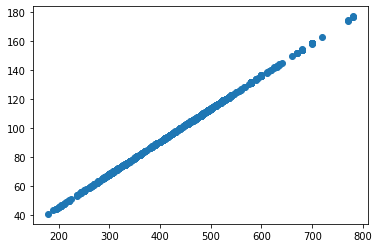

In [21]:
W1 = bayes_NMF1.get_W()
H1 = bayes_NMF1.get_H()
# 特徴量1つなので、合計種族値にほぼ比例する
plt.scatter(pokemon.iloc[:,3:9].sum(axis=1),W1)

In [22]:
pokemon['W1_bayes'] = W1
pokemon.loc[np.argsort(- W1,axis=0).flatten()[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm,W1_bayes
163,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True,150.0,ミュウツー,780,9.183720,6.631446,11.690525,13.440403,177.361022
426,Mega Rayquaza,Dragon,Flying,105,180,100,180,100,115,3,True,384.0,レックウザ,780,9.190523,6.506072,11.842140,13.511671,177.063124
164,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,150.0,ミュウツー,780,9.131998,4.763079,13.639539,14.447281,176.977164
424,Primal Groudon,Ground,Fire,100,180,160,150,90,90,3,True,383.0,グラードン,770,9.101220,9.231575,8.658577,12.656735,174.525755
422,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,382.0,カイオーガ,770,9.054753,6.967974,11.053159,13.066177,174.385979
552,Arceus,Normal,NaN,120,120,120,120,120,120,4,True,493.0,アルセウス,720,8.395973,7.283269,9.345345,11.848269,163.282317
494,Mega Garchomp,Dragon,Ground,108,170,115,120,95,92,4,False,445.0,ガブリアス,700,8.251565,7.665982,8.624707,11.539188,159.073741
418,Mega Latias,Dragon,Psychic,80,100,120,140,150,110,3,True,380.0,ラティアス,700,8.175889,7.024310,9.175415,11.555483,159.008140
268,Mega Tyranitar,Rock,Dark,100,164,150,95,120,71,2,False,248.0,バンギラス,700,8.264288,9.764774,6.341790,11.643415,158.976483
712,Kyurem White Kyurem,Dragon,Ice,125,120,90,170,100,95,5,True,646.0,キュレム,700,8.187094,5.829958,10.511508,12.019992,158.884598


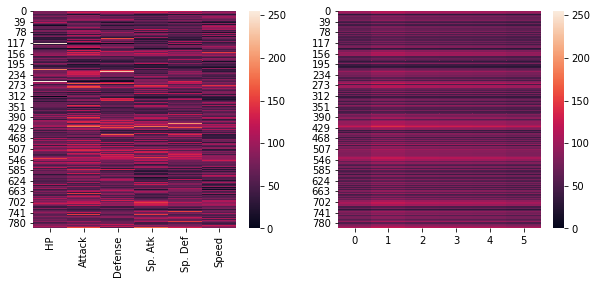

In [23]:
# ヒートマップで確認
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(X, ax=axes[0],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(W1,H1), ax=axes[1], vmin=vmin, vmax=vmax)

In [24]:
# M=2
bayes_NMF2 = NMF_model(X_for_bayes, 2)
bayes_NMF2.fit(3000)

In [25]:
W2 = bayes_NMF2.get_W()
H2 = bayes_NMF2.get_H()

In [26]:
pokemon['W2_1_bayes'] = W2[:,0]
pokemon.loc[np.argsort(- W2[:,0])[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm,W1_bayes,W2_1_bayes
268,Mega Tyranitar,Rock,Dark,100,164,150,95,120,71,2,False,248.0,バンギラス,700,8.264288,9.764774,6.341790,11.643415,158.976483,139.349033
422,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,382.0,カイオーガ,770,9.054753,6.967974,11.053159,13.066177,174.385979,137.746546
313,Slaking,Normal,NaN,150,160,100,95,65,100,3,False,289.0,ケッキング,670,7.850700,6.982462,8.548021,11.037365,152.028333,131.059693
792,Xerneas,Fairy,NaN,126,131,95,131,98,99,6,True,716.0,ゼルネアス,680,7.954907,6.386311,9.419594,11.380409,154.317726,126.316616
546,Cresselia,Psychic,NaN,120,70,120,75,130,85,4,False,488.0,クレセリア,600,6.955414,7.546909,6.077019,9.689479,135.909550,119.747060
137,Mega Pinsir,Bug,Flying,65,155,120,65,90,105,1,False,127.0,カイロス,600,7.075648,7.265885,6.634784,9.839383,136.029864,119.671182
431,Deoxys Speed Forme,Psychic,NaN,50,95,90,95,90,180,3,True,386.0,デオキシス,600,6.959937,3.732454,10.285093,10.941406,136.372531,119.609450
102,Mega Gengar,Ghost,Poison,60,65,80,170,95,130,1,False,94.0,ゲンガー,600,6.972694,3.288247,10.798862,11.288400,136.318642,119.570244
716,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False,648.0,メロエッタ,600,7.002230,5.460369,8.469822,10.077376,136.052536,119.536920
715,Meloetta Aria Forme,Normal,Psychic,100,77,77,128,128,90,5,False,648.0,メロエッタ,600,6.977731,5.232325,8.669506,10.126083,136.033023,119.520588


In [27]:
pokemon['W2_2_bayes'] = W2[:,1]
pokemon.loc[np.argsort(- W2[:,1])[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm,W1_bayes,W2_1_bayes,W2_2_bayes
543,Regigigas,Normal,NaN,110,160,110,80,110,100,4,...,486.0,レジギガス,670,7.871280,7.762597,7.732723,10.956866,151.987505,8.041026e-21,91.809935
429,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,3,...,386.0,デオキシス,600,7.095015,0.873603,13.707578,13.735388,135.991443,2.845466e+00,80.182685
423,Groudon,Ground,NaN,100,150,140,100,90,90,3,...,383.0,グラードン,670,7.885923,8.359414,7.106153,10.971655,151.676622,2.553595e+01,74.361877
670,Chandelure,Ghost,Fire,60,55,90,145,90,80,5,...,609.0,シャンデラ,520,6.063899,4.356816,7.743505,8.885027,117.872471,5.422236e-06,71.261509
736,Pyroar,Fire,Normal,86,68,72,109,66,106,6,...,668.0,カエンジシ,507,5.880680,3.620387,8.175367,8.941131,115.043716,3.227899e-50,69.544144
428,Deoxys Normal Forme,Psychic,NaN,50,150,50,150,50,150,3,...,386.0,デオキシス,600,7.055994,2.332636,12.022200,12.246407,136.477288,2.045750e+01,68.237271
164,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,...,150.0,ミュウツー,780,9.131998,4.763079,13.639539,14.447281,176.977164,6.396503e+01,63.036946
163,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,...,150.0,ミュウツー,780,9.183720,6.631446,11.690525,13.440403,177.361022,6.823457e+01,60.028524
29,Arbok,Poison,NaN,60,85,69,65,79,80,1,...,24.0,アーボック,438,5.121434,4.350664,5.801987,7.251988,99.234674,4.966323e-29,60.000164
45,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,...,40.0,プクリン,435,5.046474,3.998612,6.033003,7.237819,98.828064,1.102452e-47,59.622357


In [28]:
# つよいポケモン よわいポケモン
# そんなの ひとの かって
# ほんとうに つよい トレーナーなら
# すきなポケモンで かてるように がんばるべき
pokemon.loc[np.argsort(np.sqrt(W2[:,0]**2 + W2[:,1]**2))[:10],:]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Pokedex_No,Japanese,sum,W1_1,W2_1,W2_2,W2_norm,W1_bayes,W2_1_bayes,W2_2_bayes
16,Weedle,Bug,Poison,40,35,30,20,20,50,1,...,13.0,ビードル,195,2.256075,1.626743,2.874969,3.303293,44.204879,18.029198,14.376843
206,Sunkern,Grass,NaN,30,30,30,30,30,30,2,...,191.0,ヒマナッツ,180,2.098993,1.820817,2.336336,2.962067,40.736327,20.768013,10.349257
186,Pichu,Electric,NaN,20,40,15,35,35,60,2,...,172.0,ピチュー,205,2.383317,0.869714,3.971161,4.065282,46.475451,13.965924,18.545197
13,Caterpie,Bug,NaN,45,30,35,20,20,45,1,...,10.0,キャタピー,195,2.251764,1.882247,2.584857,3.197552,44.226348,19.050362,13.632005
188,Igglybuff,Normal,Fairy,90,30,15,40,20,15,2,...,174.0,ププリン,210,2.421196,1.906218,2.907708,3.476842,47.504331,10.836079,21.269960
303,Ralts,Psychic,Fairy,28,25,25,45,35,40,3,...,280.0,ラルトス,198,2.298741,1.358093,3.258581,3.530264,44.778961,19.851375,13.402334
255,Tyrogue,Fighting,NaN,35,35,35,35,35,35,2,...,236.0,バルキー,210,2.448825,2.124287,2.725726,3.455745,47.518021,24.068710,12.234482
288,Wurmple,Bug,NaN,45,45,35,20,30,20,3,...,265.0,ケムッソ,195,2.287508,2.627424,1.838265,3.206645,44.395618,25.635423,9.129973
317,Whismur,Normal,NaN,64,51,23,51,23,28,3,...,293.0,ゴニョニョ,240,2.805885,2.009162,3.589974,4.113957,54.316577,12.585626,24.302178
139,Magikarp,Water,NaN,20,10,55,15,20,80,1,...,129.0,コイキング,200,2.278770,1.620688,2.929584,3.347999,45.400044,0.000000,27.390294


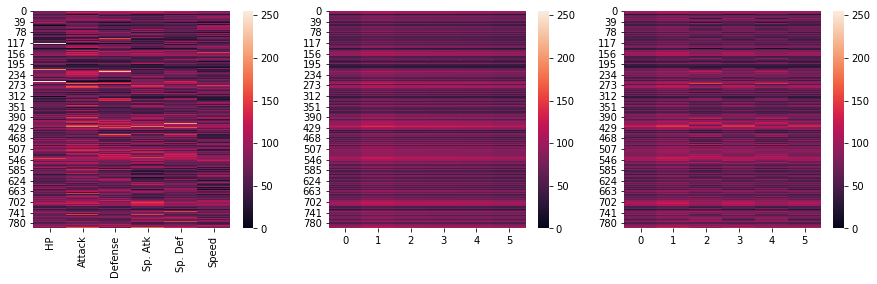

In [29]:
# ヒートマップで確認
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.heatmap(X, ax=axes[0],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(W1,H1), ax=axes[1],vmin=vmin,vmax=vmax)
sns.heatmap(np.dot(W2,H2), ax=axes[2],vmin=vmin,vmax=vmax)

~sklearnすごい~

{{ '[須山敦志. 杉山将. ベイズ推論による機械学習入門. 講談社, 2017.](https://www.kspub.co.jp/book/detail/1538320.html)' | fndetail: 1 }}